In [14]:
# Imports:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import os


In [15]:
# Load the dataset
import dataset
from dataset import PolImgDataset

dataset = PolImgDataset(
    "/home/qmissinne/MAVLab/AE4353-Y24/data/polarization_dataset",
    h5=True,
    augment=True  # Apply augmentations if you want during training
)

In [16]:
# Split the dataset into training and validation sets
from torch.utils.data import Subset

total_len = len(dataset)

# first .85 for training, rest for validation
train_len = int(0.85 * total_len)
val_len = total_len - train_len

train_indices = list(range(0, train_len))
val_indices = list(range(train_len, total_len))

train_set = Subset(dataset, list(range(0, train_len)))
val_set = Subset(dataset, list(range(train_len, total_len)))

In [17]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Subset
import random
import numpy as np


# Choose which dataset to visualize
datasets = [train_dataset]
dataset_names = ["Train"]

for dataset, dataset_name in zip(datasets, dataset_names):
    n_samples = 5
    fig, axes = plt.subplots(n_samples, 9, figsize=(18, 15))

    # Randomly pick samples from the dataset
    sample_indexes = random.sample(range(len(dataset)), n_samples)

    for i, idx in enumerate(sample_indexes):
        maps, vector, angles = dataset[idx]
        maps = maps.float().numpy()  # convert to NumPy for matplotlib
        vector = vector.float().numpy()

        # Image center and arrow radius
        h, w = maps.shape[1], maps.shape[2]
        center = (w / 2, h / 2)
        radius = 0.45 * min(h, w)

        # Plot polarization channels
        for ch in range(4):
            axes[i, ch].imshow(maps[ch], cmap="gray")
            axes[i, ch].axis("off")
            if i == 0:
                axes[i, ch].set_title(f"CH {ch+1}")

        # Compute derived quantities
        I = 0.5 * maps.sum(axis=0)
        Q = maps[0] - maps[2]
        U = maps[1] - maps[3]
        DOP = np.sqrt(Q**2 + U**2) / (I + 1e-8)  # avoid division by zero
        AOP = 0.5 * np.arctan2(U, Q)  # radians

        derived = [I, Q, U, DOP, AOP]
        derived_titles = ["I", "Q", "U", "DOP", "AOP"]
        derived_cmaps = ["gray", "gray", "gray", "gray", "hsv"]

        for j, (img, title, cmap) in enumerate(zip(derived, derived_titles, derived_cmaps)):
            col_idx = j + 4
            axes[i, col_idx].imshow(img, cmap=cmap)
            axes[i, col_idx].axis("off")
            if i == 0:
                axes[i, col_idx].set_title(title)

        # Draw ground truth arrow on all 9 images
        for j in range(9):
            axes[i, j].arrow(
                center[0],
                center[1],
                radius * vector[0],
                -radius * vector[1],
                color="red",
                head_width=3,
            )

        # Label sample index
        axes[i, 0].text(
            -0.2,
            0.5,
            f"Idx: {idx}",
            fontsize=10,
            ha="right",
            va="center",
            transform=axes[i, 0].transAxes,
            rotation=45,
        )

    plt.suptitle(f"{dataset_name} dataset - random {n_samples} samples", fontsize=16)
    plt.tight_layout()
    plt.show()

NameError: name 'train_dataset' is not defined

In [18]:
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader

# Wrap subsets with DataLoader
train_loader = DataLoader(
    train_set,
    batch_size=32,   # you can tune this (depends on GPU memory)
    shuffle=True,    # shuffle only for training
    num_workers=4    # or 0 if you’re on Windows / debugging
)

val_loader = DataLoader(
    val_set,
    batch_size=32,
    shuffle=False,   # no shuffle for validation
    num_workers=4
)

# Just check one batch
batch = next(iter(train_loader))

inputs, y_gt_vector, y_gt_angles = batch

print("Inputs shape:", inputs.shape)
print("GT vector shape:", y_gt_vector.shape)
print("GT angles shape:", y_gt_angles.shape)


/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Inputs shape: torch.Size([32, 4, 224, 224])
GT vector shape: torch.Size([32, 2])
GT angles shape: torch.Size([32])


In [19]:
# EXERCISE 1.1, 1.2, 1.3
# # We can use: raw data (4 channels), IQU, DOP+AOP, or IQU+DOP+AOP (5 channels)

def get_representation_layer(representation):
    assert representation in ["raw", "IQU", "DOP+AOP", "IQU+DOP+AOP"], "Invalid representation"

    #--------------------------------------------------------------
    # EXAMPLE 1.0: if representation is "raw", return identity layer
    #--------------------------------------------------------------
    if representation == "raw":
        channel_representation = 4
        representation_layer = nn.Identity()

    elif representation == "IQU":
        channel_representation = 3
    #--------------------------------------------------------------
    # TODO 1.1: write class for IQU representation
    #--------------------------------------------------------------
        class PolCh2IQU(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                I = 0.5 * x.sum(axis=1)
                Q = x[:, 0] - x[:, 2]
                U = x[:, 1] - x[:, 3]
                return torch.stack([I, Q, U], axis=1)

        representation_layer = PolCh2IQU()
    #--------------------------------------------------------------
    # END OF TODO 1.1
    #--------------------------------------------------------------
    elif representation == "DOP+AOP":
        channel_representation = 2
    
    #--------------------------------------------------------------
    # TODO 1.2: write class for DOP+AOP representation
    #--------------------------------------------------------------
        class PolCh2DOPAOP(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                I = 0.5 * x.sum(axis=1)
                Q = x[:, 0] - x[:, 2]
                U = x[:, 1] - x[:, 3]
                DOP = torch.sqrt(Q**2 + U**2) / I
                AOP = 0.5 * torch.arctan2(U, Q)
                return torch.stack((DOP, AOP), axis=1)

        representation_layer = PolCh2DOPAOP()
    
    #--------------------------------------------------------------
    # END OF TODO 1.2
    #--------------------------------------------------------------
    elif representation == "IQU+DOP+AOP":
        channel_representation = 5

    #--------------------------------------------------------------
    # TODO 1.3: write class for IQU+DOP+AOP representation
    #--------------------------------------------------------------
        class PolCh2IQUDOPAOP(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                I = 0.5 * x.sum(axis=1)
                Q = x[:, 0] - x[:, 2]
                U = x[:, 1] - x[:, 3]
                DOP = torch.sqrt(Q**2 + U**2) / I
                AOP = 0.5 * torch.arctan2(U, Q)
                return torch.stack((I, Q, U, DOP, AOP), axis=1)

        representation_layer = PolCh2IQUDOPAOP()

    #--------------------------------------------------------------
    # END OF TODO 1.3
    #--------------------------------------------------------------
    return representation_layer, channel_representation
        

In [20]:
# EXERCISE 2: Define the CNN architecture

import torch.nn.functional as F

class VanillaCNN(nn.Module):
    """
    A vanilla convolutional neural network model.
    with the following architecture:
    - Three convolutional layers each with 3x3 kernels, stride=1 w/ ReLU activation followed by a max pooling layer with 2x2 kernels.
    - The first layer has 16 output channels, the second has 32 output channels, and the third has 64 output channels.
    - Flatten the output of the last convolutional layer.
    - Two fully connected layers with ReLU activation with 128 hidden units and 64 hidden units.
    - One fully connected layer with linear activation as the output layer.

    Args:
        channel_in (int): Number of input channels.
        channel_out (int): Number of output channels.
        last_layer_bias (bool, optional): Whether to include bias in the last layer. Defaults to True.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        conv2 (nn.Conv2d): Second convolutional layer.
        conv3 (nn.Conv2d): Third convolutional layer.
        fc1 (nn.LazyLinear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer.
        fc3 (nn.Linear): Third fully connected layer.

    Methods:
        forward(x): Forward pass of the model.

    """

    def __init__(self, channel_in, channel_out, last_layer_bias=True):
        super().__init__()

        #--------------------------------------------------------------
        # TODO 2.1: Define the layers of the CNN as described above
        #--------------------------------------------------------------

        self.conv1 = nn.Conv2d(channel_in, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.LazyLinear(out_features=128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, channel_out, bias=last_layer_bias)
        #-------------------------------------------------------------- 
        # END OF TODO 2.1
        #--------------------------------------------------------------

    #--------------------------------------------------------------
    # TODO 2.2: Implement the forward pass
    # --------------------------------------------------------------
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
    
    #--------------------------------------------------------------
    # END OF TODO 2.2
    #--------------------------------------------------------------
        return self.fc3(x)

    def get_angle(self, outputs):
        """
        Convert the network output vector to an angle in degrees.
        """
        x = outputs[:, 0]
        y = outputs[:, 1]
        angle = torch.atan2(y, x) * 180 / torch.pi  # convert rad -> deg
        angle = torch.remainder(angle, 360)         # ensure 0-360°
        return angle

In [21]:
from tqdm.notebook import tqdm


def evaluate(dataloader, model, criterion):
    """
    Evaluate the performance of a model on a given dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader containing the evaluation data.
        model (torch.nn.Module): The model to be evaluated.
        criterion (torch.nn.Module): The loss function used for evaluation.

    Returns:
        tuple: A tuple containing the average loss, evaluation metric (mean, median, and all values), and predictions.

    """
    model.eval()

    loss = []
    pred = []
    metric = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval", leave=False):
            inputs, vector_gt, angle_gt = batch
            inputs = inputs.to(device)
            angle_gt = angle_gt.to(device)
            vector_gt = vector_gt.to(device)
            outputs = model(inputs)
            loss.append(criterion(outputs, angle_gt, vector_gt).item())
            angle_pred = model.get_angle(outputs)
            pred.extend(angle_pred.tolist())
            angle_error = torch.abs(angle_pred - angle_gt)
            angle_error = torch.min(angle_error, 360 - angle_error)
            metric.extend(angle_error.tolist())

    metric = torch.tensor(metric)
    pred = torch.tensor(pred)

    return sum(loss) / len(loss), (metric.mean(), metric.median(), metric), pred

In [22]:
from tqdm.notebook import tqdm


def train_epoch(train_loader, val_loader, model, optimizer, criterion):
    """
    Trains the model for one epoch using the provided data loaders, model, optimizer, and criterion.
    Args:
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        model (torch.nn.Module): The model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        criterion (torch.nn.Module): The loss function used for training.
    Returns:
        tuple: A tuple containing the training loss, training performance, validation performance, and validation predictions.
    """
    model.train()

    for x, y_gt_vector, y_gt_angles in tqdm(train_loader, desc="Training", leave=False):

        x = x.to(device)
        y_gt_angles = y_gt_angles.to(device)
        y_gt_vector = y_gt_vector.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y_gt_angles, y_gt_vector)
        loss.backward()

        optimizer.step()

    train_loss, train_performance, _ = evaluate(train_loader, model, criterion)
    _, val_performance, val_pred = evaluate(val_loader, model, criterion)

    return train_loss, train_performance, val_performance, val_pred

In [23]:
import matplotlib.pyplot as plt


def plot_angle_historgram(pred, gt):
    """
    Plots a histogram of angles in polar coordinates.

    Parameters:
    - pred (array-like): Array of predicted angles in degrees.
    - gt (array-like): Array of ground truth angles in degrees.

    Returns:
    fig (matplotlib.figure.Figure): The generated figure object.
    """
    fig, ax = plt.subplots(1, subplot_kw={"projection": "polar"})
    for data, data_type in zip(
        [pred, gt],
        ["Prediction", "Ground Truth"],
    ):
        ax.hist(data / 180 * 3.14, bins=100, label=data_type, alpha=0.8)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.legend()
    plt.tight_layout()
    return fig

In [24]:
class AngleVectorLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_gt_angles, y_gt_vector):
        # Example: cosine similarity loss on predicted vs. GT vector
        y_pred_norm = F.normalize(y_pred, dim=1)
        y_gt_norm = F.normalize(y_gt_vector, dim=1)
        loss = 1 - (y_pred_norm * y_gt_norm).sum(dim=1).mean()
        return loss

In [25]:
# CONFIG:

epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VanillaCNN(channel_in=4, channel_out=2, last_layer_bias=True)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = AngleVectorLoss()

val_angles = dataset.angles[val_indices]

In [26]:
from torch.utils.tensorboard import SummaryWriter

exp_name = "VanillaCNN_IQU"
writer = SummaryWriter(f"runs/{exp_name}")

for epoch in tqdm(range(epochs), desc="Epochs"):
    (
        train_loss,
        (train_error_mean, train_error_median, train_error_tensor),
        (val_err_mean, val_err_median, val_error_tensor),
        val_pred,
    ) = train_epoch(train_loader, val_loader, model, optimizer, criterion)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Error/train/mean", train_error_mean, epoch)
    writer.add_scalar("Error/train/median", train_error_median, epoch)
    writer.add_scalar("Error/val/mean", val_err_mean, epoch)
    writer.add_scalar("Error/val/median", val_err_median, epoch)
    writer.add_histogram("Error/val", train_error_tensor, epoch)
    writer.add_histogram("Pred/val", val_pred, epoch)

    writer.add_figure(
        "Polar Histogram",
        plot_angle_historgram(val_pred, val_angles),
        epoch,
    )


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Training:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

In [27]:
train_loss, train_performance, _ = evaluate(train_loader, model, criterion)

Eval:   0%|          | 0/70 [00:00<?, ?it/s]

/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),
/home/qmissinne/MAVLab/AE4353-Y24/ex_2/dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

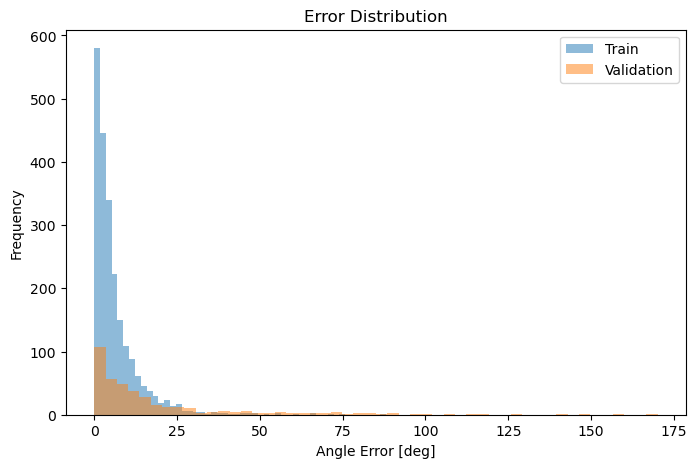

In [34]:
import matplotlib.pyplot as plt
import torch

# Convert tensors to numpy
train_errors = train_error_tensor.cpu().numpy()
val_errors = val_error_tensor.cpu().numpy()
val_preds = val_pred.cpu().numpy()

# 1. Error histogram
plt.figure(figsize=(8,5))
plt.hist(train_errors, bins=50, alpha=0.5, label="Train")
plt.hist(val_errors, bins=50, alpha=0.5, label="Validation")
plt.xlabel("Angle Error [deg]")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.legend()
plt.show()

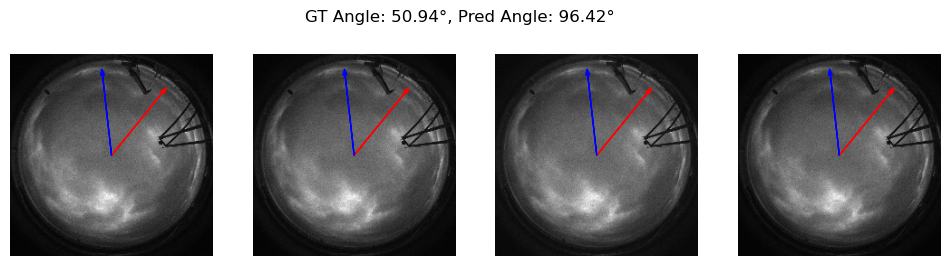

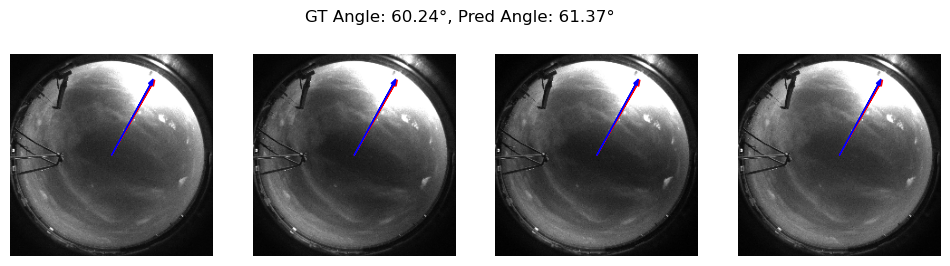

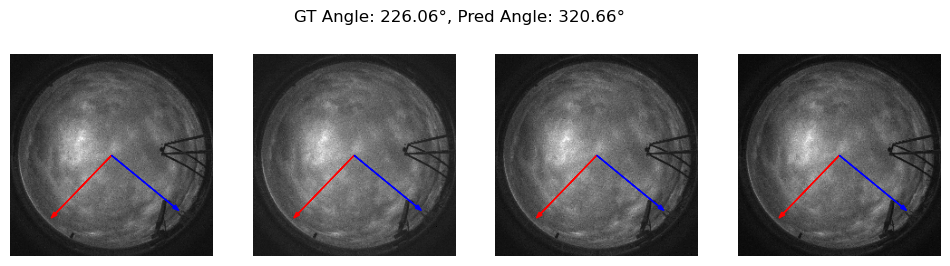

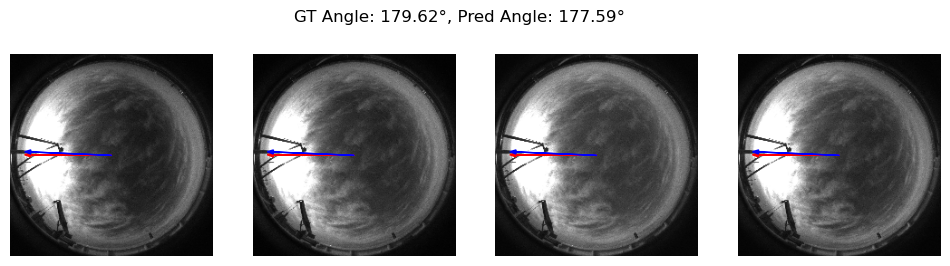

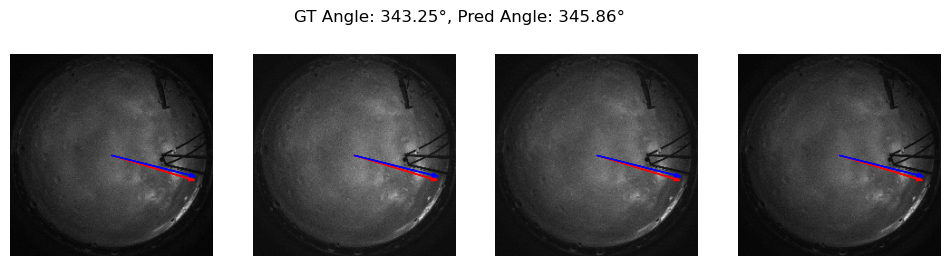

In [35]:
import matplotlib.pyplot as plt
import torch
import random

def plot_predictions_scaled(dataset, model, n_samples=5):
    """
    Plot n_samples images from the dataset with GT and predicted vectors as arrows.
    Arrows are scaled to always fit within the image bounds.
    """
    model.eval()
    sample_indices = random.sample(range(len(dataset)), n_samples)

    for i, idx in enumerate(sample_indices):
        maps, vector_gt, angle_gt = dataset[idx]

        # Move to device and add batch dimension
        maps_tensor = maps.unsqueeze(0).to(device)
        vector_pred = model(maps_tensor)
        angle_pred = model.get_angle(vector_pred)[0].item()

        # Determine image center
        height, width = maps.shape[1], maps.shape[2]
        start_pos = width // 2, height // 2

        # Determine scaling factor to ensure arrows fit inside image
        max_length = min(height, width) * 0.4  # max arrow length = 40% of image size

        # Compute GT arrow scaled
        gt_length = (vector_gt[0]**2 + vector_gt[1]**2)**0.5
        scale_gt = max_length / max(gt_length.item(), 1e-6)
        dx_gt = vector_gt[0].item() * scale_gt
        dy_gt = -vector_gt[1].item() * scale_gt  # negative because image y-axis points down

        # Compute Pred arrow scaled
        pred_vec = vector_pred[0]  # remove batch dimension
        pred_length = (pred_vec[0]**2 + pred_vec[1]**2)**0.5
        scale_pred = max_length / max(pred_length.item(), 1e-6)
        dx_pred = pred_vec[0].item() * scale_pred
        dy_pred = -pred_vec[1].item() * scale_pred

        # Plot each channel
        fig, axes = plt.subplots(1, maps.shape[0], figsize=(12, 3))
        for ch in range(maps.shape[0]):
            axes[ch].imshow(maps[ch], cmap="gray")
            axes[ch].axis("off")
            axes[ch].arrow(start_pos[0], start_pos[1], dx_gt, dy_gt,
                           color="red", head_width=max_length*0.05, label="GT")
            axes[ch].arrow(start_pos[0], start_pos[1], dx_pred, dy_pred,
                           color="blue", head_width=max_length*0.05, label="Pred")

        plt.suptitle(f"GT Angle: {angle_gt:.2f}°, Pred Angle: {angle_pred:.2f}°")
        plt.show()

plot_predictions_scaled(val_set, model, n_samples=5)